In [181]:
import pandas as pd
import numpy as np
import csv
import time
import pickle

import matplotlib.pyplot as plt
%matplotlib inline

In [182]:
def save_to_pickle_file(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_pickle_file(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [190]:
def bruteforce(n, M, pairs, print_out=True, repeat_num=1):
    keys = list(pairs.keys())
    max_num = 2**n - 1
    power2 = [2**x for x in range(n)]
    
#     best = -1
#     max_cost = 0
#     max_weight = M
#     final_keys = []
#     start_time = time.clock()
    start_time = time.process_time()
    
    for j in range(repeat_num):
        best = -1
        max_cost = 0
        max_weight = M
        final_keys = []
        
        for i in range(1, max_num + 1):
            counter = 0
            cur_weight = 0
            cur_cost = 0
            used_keys = []

#             print(15*'=')
#             print('i:', i)
#             print(8*'-')
            for pow2 in power2:
#                 print('pow2:', pow2)
                if pow2 & i:
#                     print('keys[counter]:', keys[counter])
                    used_keys.append(keys[counter])
                    cur_weight += int(keys[counter])
                    cur_cost += pairs[keys[counter]]

                counter += 1

            if cur_weight <= M and cur_cost > max_cost:
#                 print('best:', i)
#                 print('max_cost:', cur_cost)
                best = i
                max_weight = cur_weight
                max_cost = cur_cost
                final_keys = used_keys
            
#     end_time = time.clock()
    end_time = time.process_time()
    
    if print_out:
        print(10*'=', 'BRUTEFORCE', 10*'=')
        print('elapsed time:', (end_time - start_time) / repeat_num)
        print('pairs:', pairs)
        print('keys:', keys)
        print('final_keys:', final_keys)
        print('M:', M)
        print('max_weight:', max_weight)
        print('max_cost:', max_cost)
        print('best:', best)
    
    return (end_time - start_time) / repeat_num

def fill_by(n, M, pairs, sorted_keys, sorted_by='cost', print_out=True, repeat_num=1):
#     max_cost = 0
#     max_weight = 0
#     final_keys = []
    
#     start_time = time.clock()
    start_time = time.process_time()
    
    for i in range(repeat_num):
        max_cost = 0
        max_weight = 0
        final_keys = []
        
        for weight in sorted_keys:
            if max_weight + int(weight) > M:
                break

            max_weight += int(weight)
            max_cost += pairs[weight]
            final_keys.append(weight)
        
#     end_time = time.clock()
    end_time = time.process_time()
    
    if print_out:
        print(10*'=', 'SORTED BY ' + sorted_by.upper() + 'S', 10*'=')
        print('elapsed time:', (end_time - start_time) / repeat_num)
        print('pairs:', pairs)
        print('keys:', sorted_keys)
        print('final_keys:', final_keys)
        print('M:', M)
        print('max_weight:', max_weight)
        print('max_cost:', max_cost)
    
    return (end_time - start_time) / repeat_num

def measure_time(filename, print_out=True, repeat_brute=1, repeat_other=1):
    with open(filename, 'r') as inst_file:
        reader = csv.reader(inst_file, delimiter=' ', skipinitialspace=True)

        bruteforce_time = []
        sorted_by_cost_time = []
        sorted_by_weight_time = []
        sorted_by_prop_time = []
        rel_err = {'prop': []}#, 'cost': [], 'weight': []}
        dupl_counter = 1
        dupl_counter_delta = 0.00001
        for row in reader:
            n = int(row[1])
            M = int(row[2])

            pairs = {}
            proportion_pairs = {}
            for i in range(0, n*2 - 1, 2):
                if int(row[i + 3]) in pairs.keys():
                    # duplication found!
                    if print_out:
                        print(10*'-', 'File:', filename, 'row:', row[0], 'There is a duplicate key!', 10*'-')
                    
                    new_key = int(row[i + 3]) + dupl_counter*dupl_counter_delta
                    
                    dupl_counter += 1
                else:
                    new_key = int(row[i + 3])
                    
                # pair: weight - cost
                pairs[new_key] = int(row[i + 4])
                # used proportion: cost/weight
                proportion_pairs[new_key] = int(row[i + 4]) / int(row[i + 3])

    #         print('sort weights by costs in desc order')
#             weights_by_cost = sorted(pairs, key=pairs.__getitem__, reverse=True)
    #         print('weights:', weights_by_costs)
    #         print(8*'-')
    #         print('sort costs by weights in desc order')
    #         print('costs:', [value for (key, value) in sorted(pairs.items(), reverse=True)])
#             weights_by_weight = [key for (key, value) in sorted(pairs.items())]
    #         print('weights:', weights_by_weights)
    #         print(18*'=')
            # descending order
            weights_by_proportion = sorted(proportion_pairs, key=proportion_pairs.__getitem__, reverse=True)

            bruteforce_time.append(bruteforce(n, M, pairs, print_out, repeat_brute))
#             sorted_by_cost_time.append(fill_by(n, M, pairs, weights_by_cost, 'cost', print_out))
#             sorted_by_weight_time.append(fill_by(n, M, pairs, weights_by_weight, 'weight', print_out))
            sorted_by_prop_time.append(
                fill_by(n, M, pairs, weights_by_proportion, 'proportion', print_out, repeat_other)
            )

#             rel_err['cost'].append((bruteforce_time[-1] - sorted_by_cost_time[-1]) / bruteforce_time[-1])
#             rel_err['weight'].append((bruteforce_time[-1] - sorted_by_weight_time[-1]) / bruteforce_time[-1])
            rel_err['prop'].append((bruteforce_time[-1] - sorted_by_prop_time[-1]) / bruteforce_time[-1])
#             break

#     return bruteforce_time, sorted_by_cost_time, sorted_by_weight_time, sorted_by_prop_time, rel_err
    return bruteforce_time, sorted_by_prop_time, rel_err

In [220]:
# n_list = [4,10,15,20,22,25,27,30,32,35,37,40]
n_list = [20,22]

# repeat_brute = [1000,10] + (len(n_list) - 2)*[1]
repeat_brute = 1
# repeat_other = []
repeat_other = 15000

file_template = './data/inst/knap_{}.inst.dat'
# dictn = {}
    
# for n, rep_brute in zip(n_list, repeat_brute):
for n in n_list:
    dictn[n] = list(measure_time(
                    file_template.format(n), print_out=False, 
                    repeat_brute=repeat_brute, repeat_other=repeat_other)
#                     repeat_brute=rep_brute, repeat_other=repeat_other)
                   )

In [224]:
dictn[15][2]

{'prop': [0.9999589743589744,
  0.9999641025641026,
  0.9999611111111112,
  0.9999555555555556,
  0.9999611111111112,
  0.9999555555555556,
  0.9999589743589744,
  0.9999641025641026,
  0.9999555555555556,
  0.9999555555555556,
  0.9999555555555556,
  0.9999538461538461,
  0.9999611111111112,
  0.9999692307692307,
  0.9999555555555556,
  0.9999641025641026,
  0.9999641025641026,
  0.9999611111111112,
  0.9999589743589744,
  0.9999555555555556,
  0.9999692307692307,
  0.9999589743589744,
  0.99995,
  0.9999555555555556,
  0.99995,
  0.99995,
  0.9999523809523809,
  0.9999611111111112,
  0.9999589743589744,
  0.9999589743589744,
  0.9999611111111112,
  0.9999555555555556,
  0.9999641025641026,
  0.9999555555555556,
  0.9999641025641026,
  0.9999555555555556,
  0.9999641025641026,
  0.9999641025641026,
  0.9999589743589744,
  0.9999555555555556,
  0.9999555555555556,
  0.9999555555555556,
  0.9999555555555556,
  0.9999611111111112,
  0.9999555555555556,
  0.9999589743589744,
  0.999955555

In [225]:
result_file = 'result'
save_to_pickle_file(dictn, result_file)
# load_pickle_file(result_file)

In [228]:
load_pickle_file(result_file)[15][2]

{'prop': [0.9999589743589744,
  0.9999641025641026,
  0.9999611111111112,
  0.9999555555555556,
  0.9999611111111112,
  0.9999555555555556,
  0.9999589743589744,
  0.9999641025641026,
  0.9999555555555556,
  0.9999555555555556,
  0.9999555555555556,
  0.9999538461538461,
  0.9999611111111112,
  0.9999692307692307,
  0.9999555555555556,
  0.9999641025641026,
  0.9999641025641026,
  0.9999611111111112,
  0.9999589743589744,
  0.9999555555555556,
  0.9999692307692307,
  0.9999589743589744,
  0.99995,
  0.9999555555555556,
  0.99995,
  0.99995,
  0.9999523809523809,
  0.9999611111111112,
  0.9999589743589744,
  0.9999589743589744,
  0.9999611111111112,
  0.9999555555555556,
  0.9999641025641026,
  0.9999555555555556,
  0.9999641025641026,
  0.9999555555555556,
  0.9999641025641026,
  0.9999641025641026,
  0.9999589743589744,
  0.9999555555555556,
  0.9999555555555556,
  0.9999555555555556,
  0.9999555555555556,
  0.9999611111111112,
  0.9999555555555556,
  0.9999589743589744,
  0.999955555

In [189]:
dictn[4][0]

[3.125e-05]

In [95]:
print(time.process_time())

922.3125


In [17]:
print(bruteforce_time)

[2.56580872246559e-05, 2.3947548015712528e-05, 2.3519913213476684e-05, 2.3519913213476684e-05, 2.2664643665848416e-05, 2.3519913270320103e-05, 2.993443507648408e-05, 2.3519913270320103e-05, 2.2237008863612573e-05, 2.2237008863612573e-05, 2.309227841124084e-05, 2.2237008863612573e-05, 2.309227846808426e-05, 2.309227846808426e-05, 2.309227846808426e-05, 2.2237008863612573e-05, 2.2237008863612573e-05, 2.2237008863612573e-05, 2.2237008863612573e-05, 2.180937411822015e-05, 2.2237008920455992e-05, 2.309227846808426e-05, 2.2664643665848416e-05, 2.5230452422420058e-05, 2.2664643665848416e-05, 2.2664643665848416e-05, 2.309227841124084e-05, 2.2664643665848416e-05, 2.2664643722691835e-05, 2.309227841124084e-05, 2.2664643665848416e-05, 2.309227846808426e-05, 2.3519913270320103e-05, 2.309227846808426e-05, 2.437518281794837e-05, 2.3519913270320103e-05, 4.7895096031425055e-05, 2.3519913270320103e-05, 2.2237008863612573e-05, 2.309227846808426e-05, 2.309227841124084e-05, 2.309227846808426e-05, 2.309227

In [18]:
len(bruteforce_time)

50

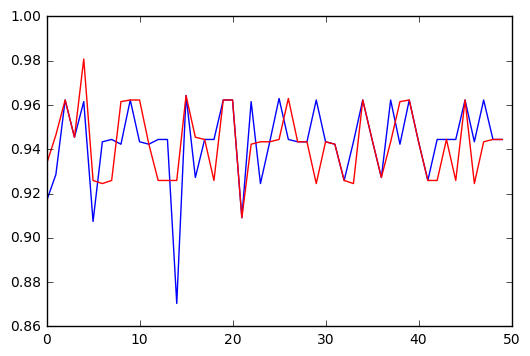

In [27]:
plt.plot(range(50), rel_err['cost'], 'b', range(50), rel_err['prop'], 'r')